# 处理特征数据

In [70]:
import pandas as pd

# 处理特征数据


product_feature_path = "data/df_product_features.csv"



item_no = "P4006"
target_col = "P4006_PA_Steel_cover_target_value"

feature_columns = """
feature_backing ## thickness
feature_backing ## weight per unit area
feature_backing ## tensile strength cd
feature_backing ## tensile strength md
feature_backing ## elongation at break cd
feature_adhesive ## tg(℃) ## dma
feature_backing ## elongation at break md
feature_adhesive ## edge taping ## 60/90
feature_adhesive ## peel adhesion (n/cm) ## sus
feature_adhesive ## peel adhesion (n/cm) ## pc
feature_adhesive ## name plate (mm) ## 30°,60/90 24hr
feature_liner ## thickness ## µm
feature_backing ## shrinkage md
feature_adhesive ## tg(℃) ## dsc
feature_adhesive ## static peel (mm) ## 50g,70℃ 24hr
feature_backing ## shrinkage cd
""".strip().split('\n')
print("original feature columns", len(feature_columns))

extra_features = ["P4004__target_value",
                  "P4080_Wgt_wto_liner_target_value",
                  "P4433_Ttl_thick_wto_liner_10n_target_value"]
feature_columns += extra_features
print(f"Feature column num: {len(feature_columns)}")
print("-" * 120)


# load data
df_product_feature = pd.read_csv(product_feature_path)

print(
    df_product_feature.head(5).to_string()
)
print("-" * 120)


# filter data for Anti-repulsion
df_data = df_product_feature[
    (df_product_feature["L1"] == "Anti-repulsion")
].copy()

print(
    "Total record number:", len(df_data)
)
print("-" * 120)


df_data = df_data[["Product Spec", "Adhesive_NART", "Liner_NART", "Backing_NART", target_col] + feature_columns]
df_data = df_data.rename(columns={target_col: "target_value"})

# 如果target_value 为空，则删除该行
df_data = df_data[df_data["target_value"].notna()]


print(
    "data preview:",
    df_data.head(5).to_string()
)
print("-" * 120)


# fill missing columns use mean
for col in feature_columns:
    if df_data[col].isnull().all():
        # all missing, drop column
        print(f"Drop column due to all missing: {col}")
        df_data = df_data.drop(columns=[col])
    else:
        # fill missing use mean
        df_data[col] = df_data[col].fillna(df_data[col].mean())



# rename feature columns
for col in df_data.columns:
    if col in feature_columns and "feature_" not in col:
        df_data = df_data.rename(columns={col: f"feature_{col}"})

print(
    "data preview:\n",
    df_data.head(5).to_string()
)
print("-" * 120)

df_data.to_csv(f"data/nn_anti_repulsion_features_{item_no}.csv", index=False, encoding="utf-8")
print(f"Saved processed data to data/nn_anti_repulsion_features_{item_no}.csv")




original feature columns 16
Feature column num: 19
------------------------------------------------------------------------------------------------------------------------
     Product Spec   P4080_value  P4080_lb  P4080_ub  P4080_Wgt_wto_liner_target_value P4433_value  P4433_lb  P4433_ub  P4433_Ttl_thick_wto_liner_10n_target_value   P4079_value  P4079_lb  P4079_ub  P4079_Wgt_after_1st_coating_wto_liner_target_value P4005_value  P4005_lb  P4005_ub  P4005_PA_Steel_open_target_value P4006_value  P4006_lb  P4006_ub  P4006_PA_Steel_cover_target_value P4007_value  P4007_lb  P4007_ub  P4007_PA_Steel_14d_open_target_value P4008_value  P4008_lb  P4008_ub  P4008_PA_Steel_14d_cover_target_value P4004_value  P4004_lb  P4004_ub  P4004__target_value P4041_value  P4041_lb  P4041_ub  P4041_HP_Steel_open_target_value P4013_value  P4013_lb  P4013_ub  P4013_PA_PC_target_value P4338_value  P4338_lb  P4338_ub  P4338_PA_steel_inside_target_value P4339_value  P4339_lb  P4339_ub  P4339_PA_steel_outside_targe

# NN train

In [84]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Define the neural network
class RegressionNet(nn.Module):
    def __init__(self, input_size):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

def run_train():
    data_path = "data/nn_anti_repulsion_features_P4006.csv"
    item_no = "P4006"
    l1_lambda = 1e-5
    l2_lambda = 1e-5

    # Load data
    try:
        df_data = pd.read_csv(data_path, sep=',')
    except FileNotFoundError:
        print(f"Error: The file at {data_path} was not found.")
        return

    # Identify feature and target columns
    feature_columns = [col for col in df_data.columns if col.startswith('feature_')]
    print(f"Feature column num: {len(feature_columns)}")

    target_column = 'target_value'

    if not feature_columns:
        print("Error: No feature columns with prefix 'feature_' found.")
        return
    if target_column not in df_data.columns:
        print(f"Error: Target column '{target_column}' not found.")
        return

    # Shuffle data with a fixed random seed
    df_data = df_data.sample(frac=1, random_state=42).reset_index(drop=True)

    # Split data and add 'is_train' column
    train_df, test_df = train_test_split(df_data, test_size=0.2, random_state=42)
    df_data['is_train'] = 0
    df_data.loc[train_df.index, 'is_train'] = 1
    print(f"Number of training samples: {len(train_df)}")
    print(f"Number of testing samples: {len(test_df)}")

    X_train = torch.tensor(train_df[feature_columns].values.astype(np.float32))
    y_train = torch.tensor(train_df[target_column].values.astype(np.float32)).view(-1, 1)
    X_test = torch.tensor(test_df[feature_columns].values.astype(np.float32))
    y_test = torch.tensor(test_df[target_column].values.astype(np.float32)).view(-1, 1)

    print(train_df[feature_columns].head().to_string())

    # Create DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize model, loss, and optimizer
    model = RegressionNet(input_size=len(feature_columns))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Prepare for saving the best model
    model_path = f'models/{item_no}_model.pt'
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    best_val_loss = float('inf')

    # Train the model
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            outputs = model(inputs)
            
            mse_loss = criterion(outputs, targets)
            
            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())

            loss = mse_loss + l1_lambda * l1_norm + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_outputs = model(X_test)
            loss = criterion(val_outputs, y_test)
            val_loss = loss.item()
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Save the model with the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)


    print(f"Best model saved to {model_path} with validation loss: {best_val_loss:.4f}")

    # Load the best trained model
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Predict on the original data
    with torch.no_grad():
        all_data_tensor = torch.tensor(df_data[feature_columns].values.astype(np.float32))
        predictions = model(all_data_tensor)
        df_data['predicted_value'] = predictions.numpy()
        print(
            "Predictions preview:\n",
            df_data[['Product Spec', 'target_value', 'predicted_value']].head(5).to_string()
        )
        print("-" * 120)

    # Save the data with predictions
    output_path = f'data/nn_{item_no}_predictions.csv'
    df_data.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")


run_train()



Feature column num: 19
Number of training samples: 25
Number of testing samples: 7
    feature_backing ## thickness  feature_backing ## weight per unit area  feature_backing ## tensile strength cd  feature_backing ## tensile strength md  feature_backing ## elongation at break cd  feature_adhesive ## tg(℃) ## dma  feature_backing ## elongation at break md  feature_adhesive ## edge taping ## 60/90  feature_adhesive ## peel adhesion (n/cm) ## sus  feature_adhesive ## peel adhesion (n/cm) ## pc  feature_adhesive ## name plate (mm) ## 30°,60/90 24hr  feature_liner ## thickness ## µm  feature_backing ## shrinkage md  feature_adhesive ## tg(℃) ## dsc  feature_adhesive ## static peel (mm) ## 50g,70℃ 24hr  feature_backing ## shrinkage cd  feature_P4004__target_value  feature_P4080_Wgt_wto_liner_target_value  feature_P4433_Ttl_thick_wto_liner_10n_target_value
25                        12.000                                   16.800                               30.000000                         

In [85]:
# 从保存的文件中读取预测结果
df_nn_result = pd.read_csv(f'data/nn_{item_no}_predictions.csv')
# 显示数据print(df_pred[["target_value", "predicted_value", "is_train"]].to_string())print("-" * 120)# 在is_train = 0上计算target_value predicted_value 的R2系数from sklearn.metrics import r2_score, mean_squared_error
test_data = df_pred[df_pred["is_train"] == 0]
r2_test = r2_score(test_data["target_value"], test_data["predicted_value"])
mse_test = mean_squared_error(test_data["target_value"], test_data["predicted_value"])

print(f"\nTest Set (is_train=0) Metrics:")
print(f"  R² Score: {r2_test:.4f}")
print(f"  MSE:      {mse_test:.4f}")

# 也计算训练集的指标作为对比
train_data = df_pred[df_pred["is_train"] == 1]
r2_train = r2_score(train_data["target_value"], train_data["predicted_value"])
mse_train = mean_squared_error(train_data["target_value"], train_data["predicted_value"])

print(f"\nTrain Set (is_train=1) Metrics:")
print(f"  R² Score: {r2_train:.4f}")
print(f"  MSE:      {mse_train:.4f}")





Test Set (is_train=0) Metrics:
  R² Score: 0.5494
  MSE:      0.2786

Train Set (is_train=1) Metrics:
  R² Score: 0.3441
  MSE:      1.3389


# Linear regression

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Configuration
data_path = "data/nn_anti_repulsion_features_P4006.csv"
item_no = "P4006"

# Load data
try:
    df_data = pd.read_csv(data_path, sep=',')
    print(f"Data loaded successfully: {len(df_data)} rows")
except FileNotFoundError:
    print(f"Error: The file at {data_path} was not found.")
    raise

# Identify feature and target columns
feature_columns = [col for col in df_data.columns if col.startswith('feature_')]
target_column = 'target_value'

print(f"Feature column num: {len(feature_columns)}")
print(f"Target column: {target_column}")

if not feature_columns:
    raise ValueError("Error: No feature columns with prefix 'feature_' found.")
if target_column not in df_data.columns:
    raise ValueError(f"Error: Target column '{target_column}' not found.")

# Check for missing values
print("\nChecking for missing values...")
missing_features = df_data[feature_columns].isnull().sum()
missing_target = df_data[target_column].isnull().sum()
print(f"Missing values in target: {missing_target}")
print(f"Missing values in features: {missing_features[missing_features > 0].sum()}")

# Drop rows with missing target values
if missing_target > 0:
    print(f"Dropping {missing_target} rows with missing target values")
    df_data = df_data.dropna(subset=[target_column])

# Fill missing feature values with mean (if any)
for col in feature_columns:
    if df_data[col].isnull().any():
        mean_val = df_data[col].mean()
        df_data[col].fillna(mean_val, inplace=True)
        print(f"Filled missing values in {col} with mean: {mean_val:.4f}")

print(f"Final dataset size: {len(df_data)} rows")
print("-" * 120)

# Shuffle data with a fixed random seed
df_data = df_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split data and add 'is_train' column
train_df, test_df = train_test_split(df_data, test_size=0.2, random_state=42)
df_data['is_train'] = 0
df_data.loc[train_df.index, 'is_train'] = 1

print(f"Number of training samples: {len(train_df)}")
print(f"Number of testing samples: {len(test_df)}")
print("-" * 120)

# Prepare training and testing data
X_train = train_df[feature_columns].values
y_train = train_df[target_column].values
X_test = test_df[feature_columns].values
y_test = test_df[target_column].values

# Train Linear Regression model
print("Training Linear Regression model...")
model = LinearRegression()
model.fit(X_train, y_train)
print("Model trained successfully!")
print("-" * 120)

# Evaluate on training set
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
print(f"Training Set Performance:")
print(f"  MSE: {train_mse:.4f}")
print(f"  R²:  {train_r2:.4f}")
print("-" * 120)

# Evaluate on test set
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test Set Performance:")
print(f"  MSE: {test_mse:.4f}")
print(f"  R²:  {test_r2:.4f}")
print("-" * 120)

# Predict on the original data
df_data['predicted_value'] = model.predict(df_data[feature_columns].values)

# Save the data with predictions
output_path = f'data/lr_{item_no}_predictions.csv'
df_data.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

# Display sample predictions
print("\nSample predictions:")
print(df_data[['target_value', 'predicted_value', 'is_train']].head(10).to_string())



Data loaded successfully: 32 rows
Feature column num: 19
Target column: target_value

Checking for missing values...
Missing values in target: 0
Missing values in features: 0
Final dataset size: 32 rows
------------------------------------------------------------------------------------------------------------------------
Number of training samples: 25
Number of testing samples: 7
------------------------------------------------------------------------------------------------------------------------
Training Linear Regression model...
Model trained successfully!
------------------------------------------------------------------------------------------------------------------------
Training Set Performance:
  MSE: 0.1657
  R²:  0.9188
------------------------------------------------------------------------------------------------------------------------
Test Set Performance:
  MSE: 0.2387
  R²:  0.6139
-------------------------------------------------------------------------------------

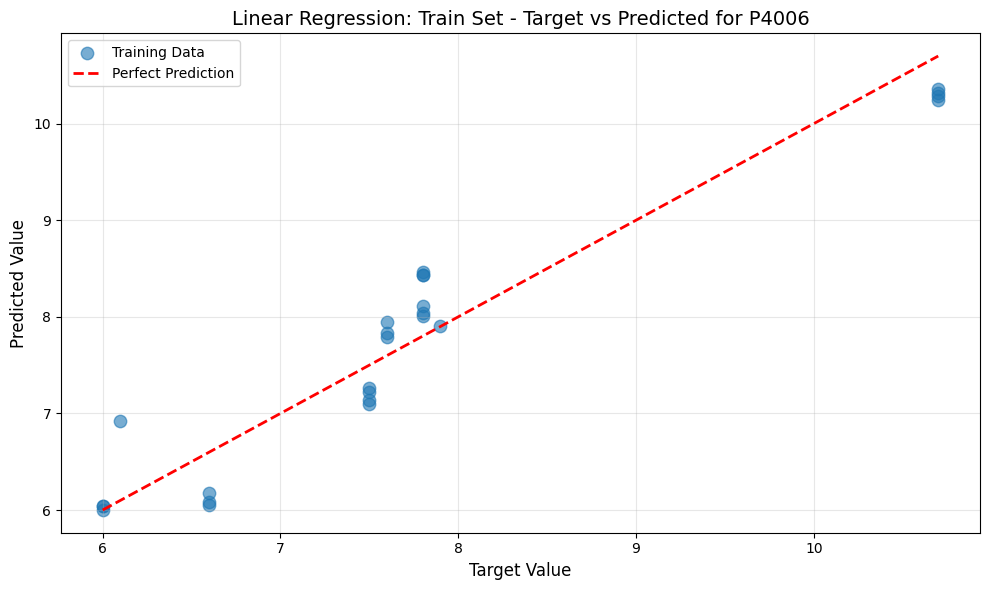

Training Set Metrics:
  MSE: 0.1657
  R²:  0.9188


In [ ]:
# 可视化训练集的预测结果
import matplotlib.pyplot as plt

df_lr_pred = pd.read_csv(f"data/lr_{item_no}_predictions.csv")

plt.figure(figsize=(10, 6))
plt.scatter(
    df_lr_pred[df_lr_pred["is_train"] == 1]["target_value"],
    df_lr_pred[df_lr_pred["is_train"] == 1]["predicted_value"],
    alpha=0.6,
    s=80,
    label='Training Data'
)
plt.grid(alpha=0.3)
plt.title(f"Linear Regression: Train Set - Target vs Predicted for {item_no}", fontsize=14)
plt.xlabel("Target Value", fontsize=12)
plt.ylabel("Predicted Value", fontsize=12)

# 添加45度参考线
min_val = df_lr_pred["target_value"].min()
max_val = df_lr_pred["target_value"].max()
plt.plot([min_val, max_val], [min_val, max_val], 
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.legend()
plt.tight_layout()
plt.show()

# 计算训练集指标
from sklearn.metrics import mean_squared_error, r2_score
train_data = df_lr_pred[df_lr_pred["is_train"] == 1]
mse_train = mean_squared_error(train_data["target_value"], train_data["predicted_value"])
r2_train = r2_score(train_data["target_value"], train_data["predicted_value"])

print(f"Training Set Metrics:")
print(f"  MSE: {mse_train:.4f}")
print(f"  R²:  {r2_train:.4f}")



# P4006: Peel adhesion/Steel, covered side (180° method), 
# Product: Anti-repulsion

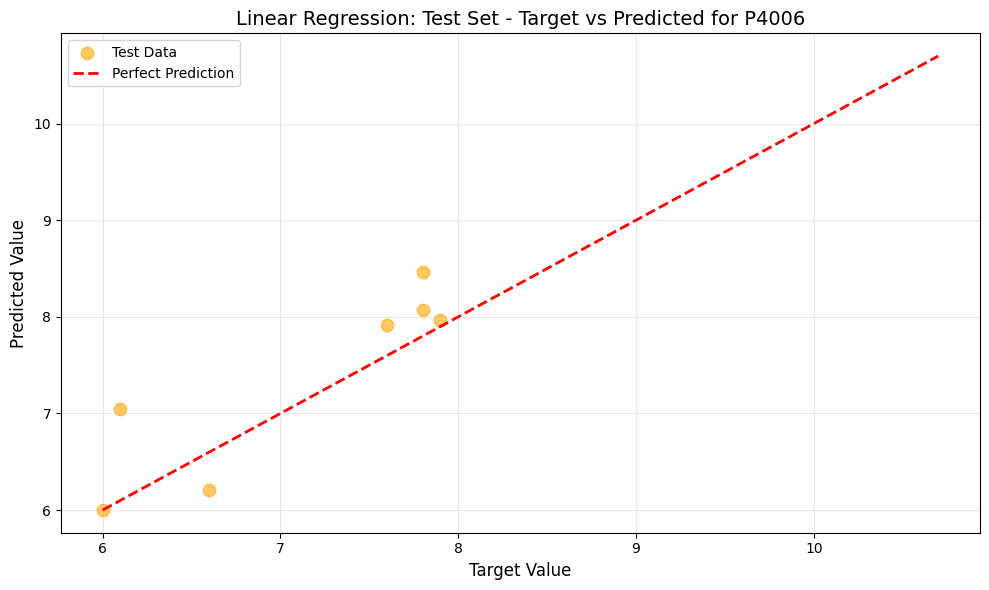

Test Set Metrics:
  MSE: 0.2387
  R²:  0.6139


In [ ]:
# 可视化测试集的预测结果
plt.figure(figsize=(10, 6))
plt.scatter(
    df_lr_pred[df_lr_pred["is_train"] == 0]["target_value"],
    df_lr_pred[df_lr_pred["is_train"] == 0]["predicted_value"],
    alpha=0.6,
    s=80,
    color='orange',
    label='Test Data'
)
plt.grid(alpha=0.3)
plt.title(f"Linear Regression: Test Set - Target vs Predicted for {item_no}", fontsize=14)
plt.xlabel("Target Value", fontsize=12)
plt.ylabel("Predicted Value", fontsize=12)

# 添加45度参考线
plt.plot([min_val, max_val], [min_val, max_val], 
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.legend()
plt.tight_layout()
plt.show()

# 计算测试集指标
test_data = df_lr_pred[df_lr_pred["is_train"] == 0]
mse_test = mean_squared_error(test_data["target_value"], test_data["predicted_value"])
r2_test = r2_score(test_data["target_value"], test_data["predicted_value"])

print(f"Test Set Metrics:")
print(f"  MSE: {mse_test:.4f}")
print(f"  R²:  {r2_test:.4f}")


# P4006: Peel adhesion/Steel, covered side (180° method), 
# Product: Anti-repulsion